In [1]:
import javalang
import json
import re
import time
import random
import nltk
nltk.download('punkt')
import numpy as np
import pickle
import tensorflow as tf
#tf.enable_eager_execution() 
import os
import matplotlib.pyplot as plt
import math

[nltk_data] Downloading package punkt to /home/yurong/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Function declaration

In [2]:
'''
Function：
    Input the code token list, comment string，and return whether it's invalid
The rule of valid method:
    1. code token size <= 100
    2. One-sentence-comment（I hope model generate only one sentence.
       If training data consist multi-sentence comment, the effect will be bad and the first sentence only can not
       properly describe the functionality of the method）

PS: I regard "tester", "setter", "getter" and "constructor" as valid method
'''
def is_invalid_method(token_len, nl):   
    if token_len > 100:
        return True
    if len(nl.split('.')) != 1 or len(nltk.word_tokenize(nl)) > 30:
        return True
    else :
        return False


    
    
'''
Function: 
    Input the root of AST and the deep of the tree, 
    it will filter the null value and return the list of SBT (structural-based travesal) and print the tree structure
'''
def parse_tree(root, deep):

    seq = []
    seq.extend(['(', str(root).split('(')[0]])
    #print('\t'*(deep)+str(root).split('(')[0])    # show node name
    for attr in root.attrs:
        if eval('root.%s' % attr) in [None, [], "", set(), False]:    # filter the null attr
            continue
        elif isinstance(eval('root.%s' % attr), list):
            x = eval('root.%s' % attr)
            if not all(elem in x for elem in [None, [], "", set(), False]):    # if not all elements in list are null
                seq.extend(['(',attr])
                #print('\t'*(deep+1)+attr)
                #deep += 1
                for i in eval('root.%s' % attr):    # recursive the list
                    if i is None or isinstance(i, str):    # perhaps it has None value in the list
                        continue
                    #deep += 1
                    seq.extend(parse_tree(i, deep))
                    
                    #deep -= 1
                #deep -= 1
                seq.extend([')',attr])
        elif 'tree' in str(type(eval('root.%s' % attr))):    #if the attr is one kind of Node, recursive the Node
            seq.extend(['(',attr])
            #print('\t'*(deep+1)+attr)
            #deep += 2
            seq.extend(parse_tree(eval('root.%s' % attr), deep))
            #deep -= 2
            seq.extend([')',attr])
        else:
            seq.extend(['(','<'+str(attr)+'>_'+str(eval('root.%s' % attr)),')','<'+str(attr)+'>_'+str(eval('root.%s' % attr))])
            #exec("print('\t'*(deep+1)+attr+': '+str(root.%s))" % attr)    #it must be normal attribute
    seq.extend([')', str(root).split('(')[0]])
    return seq




'''
Function:
    1. "camelCase" -> ["camel", "Case"]
    2. "under_score" -> ["under", "_", "score"]
    3. "normal" -> ["normal"]
'''
def split_identifier(id_token):
    if  "_" in id_token:
        return id_token.split("_")
    elif id_token != id_token.lower() and id_token != id_token.upper():
        matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', id_token)
        return [m.group(0) for m in matches]
    else:
        return [id_token]

    
    
'''
Function:
    1. input the list of train, test, valid dataset
    2. filter the dataset, split it to train, test, valid set and save as the smaller dataset.
    3. return the amount of the data from smaller datasets.
Example:
    filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './data')
Note:
    The filter method is different from the method in DeepCom, because I have no idea how DeepCom did.
    It doesn't make sense that DeepCom could filter so many data via the method mentioned in its paper.
'''
def filter_dataset(path_list, save_path):
    
    inputs = []
    for path in path_list:
        input_file = open(path)
        inputs.extend(input_file.readlines())
        input_file.close()
    outputs = []
    output_train_file = open(save_path+'/filter_train.json', "w")
    output_test_file = open(save_path+'/filter_test.json', "w")
    output_valid_file = open(save_path+'/filter_valid.json', "w")
    
    print('Original total: '+str(len(inputs)))
    for pair in inputs:
        pair = json.loads(pair)
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        if is_invalid_method(len(list(tokens_parse)), pair['nl']):
            continue
        outputs.append(json.dumps(pair))

    random.shuffle(outputs)
    print('Final total: '+str(len(outputs)))
    print('Data shuffle complete')
    train_index = int(len(outputs)*0.8)
    test_index = int(len(outputs)*0.9)
    train_output = outputs[:train_index]
    test_output = outputs[train_index+1:test_index]
    valid_output = outputs[test_index+1:]
    
    for row in train_output:
        output_train_file.write(row+'\n')
    output_train_file.close()
    print('filter train data finish writing')
    for row in test_output:
        output_test_file.write(row+'\n')
    output_test_file.close()
    print('filter test data finish writing')
    for row in valid_output:
        output_valid_file.write(row+'\n')
    print('filter valid data finish writing')
    output_valid_file.close()

    return len(train_output), len(test_output), len(valid_output)


'''
Parameters:
    path: the path of the data you want to read
    code_voc: code vocabulary, the data type is list
    comment_voc: comment vocabulary, the data type is list
Return values:
    code_tokens, comment_tokens: 2-dimension list, store the code and comment into list, snippet by snippet
    code_voc, comment_voc: the all vocabularies in the file of the path, data type is list
Note:
    It hasn't used SBT in DeepCom.
TODO:
    Change the rare words in comments into other common words via pre-trained embedding
'''
def readdata(path, code_voc, comment_voc):
    input_file = open(path)
    inputs = input_file.readlines()

    code_tokens = []          # code_tokens = ['<START>', '<Modifier>', 'public', '<Identifier>',....]
    comment_tokens = []       # comment_tokens = []

    start = time.time()
    for index, pair in enumerate(inputs):
        if index%5000 == 0 and index != 0:
            print(index)
        pair = json.loads(pair)
        # =============== extract the code part of the snippet =========================
        
        #TODO: 以下寫成另一個function，切token的部分
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        tokens = []
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
            temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
            temp.extend(splitted_id)
            tokens.extend(temp)
            for x in tokens:
                if x not in code_voc:
                    code_voc.append(x)
        tokens.insert(0, '<START>')
        tokens.append('<END>')
        code_tokens.append(tokens)
        
        #=============== extract comment part of the snippet ==========================
        tokens = nltk.word_tokenize(pair['nl'])
        tokens.append('<END>')
        comment_tokens.append(tokens)
        for x in tokens:
            if x not in comment_voc:
                comment_voc.append(x)

    print('readdata:')
    print('\tdata amount: '+str(len(code_tokens)))
    print('\trun time: '+str(time.time()-start))

    input_file.close()
    return code_tokens, comment_tokens, code_voc, comment_voc

def simple_readdata(path, code_voc, comment_voc):
    input_file = open(path)
    inputs = input_file.readlines()

    code_tokens = []          
    comment_tokens = []       # comment_tokens = []

    start = time.time()
    for index, pair in enumerate(inputs):
        if index%5000 == 0 and index != 0:
            print(index)
        pair = json.loads(pair)
        # =============== extract the code part of the snippet =========================
        
        #TODO: 以下寫成另一個function，切token的部分
        tokens_parse = javalang.tokenizer.tokenize(pair['code'])
        tokens = []
        for token in tokens_parse:    # iterate the tokens of the sentence
            token = str(token).split(' ')
            splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
            #temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
            #temp = []
            #temp.extend(splitted_id)
            tokens.extend(splitted_id)
            for x in tokens:
                if x not in code_voc:
                    code_voc.append(x)
        tokens.insert(0, '<START>')
        tokens.append('<END>')
        code_tokens.append(tokens)
        
        #=============== extract comment part of the snippet ==========================
        tokens = nltk.word_tokenize(pair['nl'])
        tokens.append('<END>')
        comment_tokens.append(tokens)
        for x in tokens:
            if x not in comment_voc:
                comment_voc.append(x)

    print('readdata:')
    print('\tdata amount: '+str(len(code_tokens)))
    print('\trun time: '+str(time.time()-start))

    input_file.close()
    return code_tokens, comment_tokens, code_voc, comment_voc

'''
Usage:
    Transform the token to the index in vocabulary
    ['<START>', '<Modifier>', 'public', ..., '<Separator>', ';', '<Separator>', '}', '<END>']
    => [0, 7, 8, ..., 14, 29, 14, 30, 1]
Parameter data type: 
    2-dimension list
Return data type:
    2-dimension list
'''
def token2index(lst, voc):
    for index, seq in enumerate(lst):
        seq_index = []
        for token in seq:
            seq_index.append(voc.index(token))
        lst[index] = seq_index
    return lst


'''
Parameters:
    lst: the list of sequences to be padded
    pad_data: the value you want to pad
Return type:
    numpy array
'''
def pad_sequences(lst, pad_data):
    maxlen = max(len(x) for x in lst)
    for index, seq in enumerate(lst):
        lst[index].extend([pad_data] * (maxlen-len(seq)))
    return np.array(lst)

'''
Parameters:
    x: the list of data
    batch_sz: batch size
Return shape:
    [None, batch_sz, None]
Example:
    a = [1,2,3,4,5,6,7,8,9,10]
    a = getBatch(x=a, batch_sz=3)
    a
    ---output---
    [[1,2,3], [4,5,6], [7,8,9]]
'''
def getBatch(x, batch_sz):
    dataset = []
    while(len(x)>=batch_sz):
        dataset.append(x[:batch_sz])
        x = x[batch_sz:]
    if type(x) == np.ndarray:
        return np.array(dataset)
    elif type(x) == list:
        return dataset
    
def ngram(words, n):
    return list(zip(*(words[i:] for i in range(n))))

def bleu4(true, pred):
    true = nltk.word_tokenize(true)
    pred = nltk.word_tokenize(pred)
    c = len(pred)
    r = len(true)
    bp = 1. if c > r else np.exp(1 - r / (c + 1e-10))
    score = 0
    for i in range(1, 5):
        true_ngram = set(ngram(true, i))
        pred_ngram = ngram(pred, i)
        
        length = float(len(pred_ngram)) + 1e-10
        count = sum([1. if t in true_ngram else 0. for t in pred_ngram])
        score += math.log(1e-10 + (count / length))
    score = math.exp(score * .25)
    bleu = bp * score
    return bleu

# TODO: 必須解決test set有可能有<UNK>，不然沒辦法translate test set
def evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    tokens_parse = javalang.tokenizer.tokenize(code)
    inputs = []
    for token in tokens_parse:    # iterate the tokens of the sentence
        token = str(token).split(' ')
        splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
        temp = ['<'+token[0]+'>']    # token[0] is token type, token[1] is token value
        temp.extend(splitted_id)
        inputs.extend(temp)

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    inputs += ['<PAD>'] * (max_length_inp - len(inputs))
    for index, token in enumerate(inputs):
        if token not in code_voc:
            inputs[index] = code_voc.index('<UNK>')
        else:
            inputs[index] = code_voc.index(token)
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''
    
    #hidden = [tf.zeros((1, units))]
    #enc_out, enc_hidden = encoder(inputs, hidden)
    #dec_hidden = enc_hidden
    
    hidden_h, hidden_c = tf.zeros((1, units)), tf.zeros((1, units))
    hidden = [hidden_h, hidden_c]
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    
    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = [dec_hidden_h, dec_hidden_c]
        #predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        result += comment_voc[predicted_id] + ' '
        
    
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot

def simple_evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    tokens_parse = javalang.tokenizer.tokenize(code)
    inputs = []
    for token in tokens_parse:    # iterate the tokens of the sentence
        token = str(token).split(' ')
        splitted_id = split_identifier(token[1].strip('"'))    # split the camelCase and under_score
        inputs.extend(splitted_id)

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    inputs += ['<PAD>'] * (max_length_inp - len(inputs))
    for index, token in enumerate(inputs):
        if token not in code_voc:
            inputs[index] = code_voc.index('<UNK>')
        else:
            inputs[index] = code_voc.index(token)
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''
    
    #hidden = [tf.zeros((1, units))]
    #enc_out, enc_hidden = encoder(inputs, hidden)
    #dec_hidden = enc_hidden
    
    hidden_h, hidden_c = tf.zeros((1, units)), tf.zeros((1, units))
    hidden = [hidden_h, hidden_c]
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    
    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = [dec_hidden_h, dec_hidden_c]
        #predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()
        predicted_id = tf.argmax(predictions[0]).numpy()
        
        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        result += comment_voc[predicted_id] + ' '
    
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot



# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()
    

def translate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    result, code, attention_plot = evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)

def simple_translate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    result, code, attention_plot = simple_evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)

    #attention_plot = attention_plot[:len(result.split(' ')), :len(code.split(' '))]
    #plot_attention(attention_plot, code.split(' '), result.split(' '))
    return result

## Prune the original big dataset into simpler and better dataset
* #### Size of training set, testing set and valid set ->  (81932, 10241, 10241)
* #### If you already have "filter_train.json", "filter_test.json" and "filter_valid.json", then you can skip this code cell.

In [7]:
filter_dataset(['./data/train.json', './data/test.json', './data/valid.json'], './filter_dataset')


Original total: 588108
Final total: 101220
Data shuffle complete
filter train data finish writing
filter test data finish writing
filter valid data finish writing


(80976, 10121, 10121)

## Reading training data (it costs about 40 mins)
* #### If you already have 'train_data.pkl', you can skip this code cell below and directly read 'train_data.pkl'

In [52]:
code_voc = ['<PAD>','<START>','<END>','<UNK>']
comment_voc = ['<PAD>','<START>','<END>','<UNK>']
code_train, comment_train, code_voc, comment_voc = simple_readdata('./filter_dataset/filter_train.json', code_voc, comment_voc)
#code_train, comment_train, code_voc, comment_voc = readdata('./filter_dataset/filter_train.json', code_voc, comment_voc)
#code_test, comment_test, code_voc, comment_voc = readdata('./filter_dataset/filter_test.json', code_voc, comment_voc)

code_train = token2index(code_train, code_voc)
comment_train = token2index(comment_train, comment_voc)
code_train = pad_sequences(code_train, code_voc.index('<PAD>'))
comment_train = pad_sequences(comment_train, comment_voc.index('<PAD>'))
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

# Saving the training data:
with open('train_simple_data.pkl', 'wb') as f:
    pickle.dump([code_train, comment_train, code_voc, comment_voc], f)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
readdata:
	data amount: 80976
	run time: 2137.429878473282
size of code vocabulary:  42137
size of comment vocabulary:  29404


In [3]:
# Getting back the training data:
with open('train_simple_data.pkl', 'rb') as f:
    code_train, comment_train, code_voc, comment_voc = pickle.load(f)
    
print('size of code vocabulary: ', len(code_voc))
print('size of comment vocabulary: ', len(comment_voc))

size of code vocabulary:  42137
size of comment vocabulary:  29404


## Just test the functionality of transforming source code to SBT

In [ ]:
input_file = open('./data/test.json')
inputs = input_file.readlines()
pair = json.loads(inputs[0])
tree = javalang.parse.parse('class aa {'+pair['code']+'}')
print(pair['code'], end='\n')

_, node = list(tree)[2]    # 前兩個用來篩掉class aa{ }的部分
seq = parse_tree(node, 0)
for i in seq:
    print(i,end='')


## Set hyper-parameters and some variables

In [4]:
BUFFER_SIZE = len(code_train)
BATCH_SIZE = 32
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(code_voc)
vocab_tar_size = len(comment_voc)

max_length_inp = max(len(t) for t in code_train)
max_length_targ = max(len(t) for t in comment_train)

## Define the deep learing models

In [5]:
def lstm(units):
    return tf.keras.layers.LSTM(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

def gru(units):
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.enc_units)
        #self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state_h, state_c = self.lstm(x, initial_state = hidden)        
        #output, state = self.gru(x, initial_state = hidden) 
        return output, state_h, state_c
        #return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units)), tf.zeros((self.batch_sz, self.enc_units))
    #def initialize_hidden_state(self):
    #    return tf.zeros((self.batch_sz, self.enc_units))

class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.lstm = lstm(self.dec_units)
        #self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden[1], 1)
        #hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the LSTM
        output, state_h, state_c = self.lstm(x)
        #output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state_h, state_c, attention_weights
        #return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units)), tf.zeros((self.batch_sz, self.dec_units))
    #def initialize_hidden_state(self):
    #    return tf.zeros((self.batch_sz, self.dec_units))

## Build the encoder, decoder and define the optimizer and the loss function

In [6]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)  #tensorflow 2.0
#optimizer = tf.train.AdamOptimizer()

def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)

## define the checkpoint object

In [7]:
checkpoint_dir = './training_checkpoints/adam-simple-256-50epochs'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)
lossArray = np.array([])

## read english and french data to test the model

In [9]:
lossArray = np.array([])
from sklearn.model_selection import train_test_split
f = open('./en.txt', 'r', encoding='utf-8')
en_lines = f.read().split('\n')
f.close()

f = open('./fr.txt', 'r', encoding='utf-8-sig')
fr_lines = f.read().split('\n')
f.close()

en_sent = []
en_words = ['<PAD>','<START>','<END>','<UNK>']
fr_sent = []
fr_words = ['<PAD>','<START>','<END>','<UNK>']


# 把每句英法文做tokenize，存到en_sent, fr_sent。
# 把所有出現過的英法單字存到，en_words, fr_words。
for line in en_lines:
    words = nltk.word_tokenize(line)
    en_sent.append(words)
    for x in words:
        if x not in en_words:
            en_words.append(x)
            
for line in fr_lines:
    words = nltk.word_tokenize(line)
    fr_sent.append(words)
    for x in words:
        if x not in fr_words:
            fr_words.append(x)


#替句子前後加上標籤
for sent in en_sent:
    sent.insert(0, '<START>')
    sent.append('<END>')
for sent in fr_sent:
    sent.insert(0, '<START>')
    sent.append('<END>')

# 製作word, index對應字典
#en_word_index = dict(
#    [(word, i+4) for i, word in enumerate(en_words)])
#fr_word_index = dict(
#    [(word, i+4) for i, word in enumerate(fr_words)])

#en_word_index_rev = dict(
#    [(i+4, word) for i, word in enumerate(en_words)])
#fr_word_index_rev = dict(
#    [(i+4, word) for i, word in enumerate(fr_words)])


#en_word_index['<PAD>'] = 0
#en_word_index['<START>'] = 1
#en_word_index['<END>'] = 2
#en_word_index['<UNK>'] = 3

#fr_word_index['<PAD>'] = 0
#fr_word_index['<START>'] = 1
#fr_word_index['<END>'] = 2
#fr_word_index['<UNK>'] = 3
    

# 英法文單字種類數
#num_en_words = len(en_word_index)
#num_fr_words = len(fr_word_index)
# 英法句子最長長度
max_len_en = max([len(x) for x in en_sent])
max_len_fr = max([len(x) for x in fr_sent])


# 把sentence從word換成index形式，e.g. ['I','like','banana'] => [56,35,71]
for sent in en_sent:
    for i, token in enumerate(sent):
        sent[i] = en_words.index(token)

for sent in fr_sent:
    for i, token in enumerate(sent):
        sent[i] = fr_words.index(token)
        

en_sent = tf.keras.preprocessing.sequence.pad_sequences(en_sent,
                                                        value=en_words.index("<PAD>"),
                                                        padding='post',
                                                        truncating='post',
                                                        maxlen=max_len_en)

fr_sent = tf.keras.preprocessing.sequence.pad_sequences(fr_sent,
                                                        value=fr_words.index("<PAD>"), 
                                                        padding='post', 
                                                        truncating='post', 
                                                        maxlen=max_len_fr)

en_train, en_test, fr_train, fr_test = train_test_split(en_sent, fr_sent, test_size=0.1, random_state=42)


# decoder的input結尾去掉<END>
# decoder的output開頭去掉<START>
fr_output_train = fr_train[:,1:]
fr_output_test = fr_test[:,1:]

fr_input_train = fr_train
fr_input_train = np.where(fr_input_train==fr_words.index('<END>'), fr_words.index('<PAD>'), fr_input_train)
fr_input_train = np.delete(fr_input_train, 26, 1)



## En to fr version: build the model and optimizer and define evaluate function

In [ ]:
BUFFER_SIZE = len(en_train)
BATCH_SIZE = 32
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 256

encoder = Encoder(len(en_words), embedding_dim, units, BATCH_SIZE)
decoder = Decoder(len(fr_words), embedding_dim, units, BATCH_SIZE)

optimizer = tf.optimizers.Adam(learning_rate=1e-3)  #tensorflow 2.0
#optimizer = tf.train.AdamOptimizer()

In [ ]:
def loss_function(real, pred):
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  return tf.reduce_mean(loss_)


def evaluate(code, encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    #tokens_parse = javalang.tokenizer.tokenize(code)
    inputs = nltk.word_tokenize(code)
    #inputs = []

    inputs.insert(0, '<START>')
    inputs.append('<END>')
    inputs += ['<PAD>'] * (max_length_inp - len(inputs))
    for index, token in enumerate(inputs):
        if token not in code_voc:
            inputs[index] = code_voc.index('<UNK>')
        else:
            inputs[index] = code_voc.index(token)
    inputs = np.array(inputs)
    inputs = tf.expand_dims(inputs, 0)
    
    result = ''

    
    #hidden = [tf.zeros((1, units))]
    #enc_out, enc_hidden = encoder(inputs, hidden)
    #dec_hidden = enc_hidden
    
    hidden_h, hidden_c = tf.zeros((1, units)), tf.zeros((1, units))
    hidden = [hidden_h, hidden_c]
    enc_output, enc_hidden_h, enc_hidden_c = encoder(inputs, hidden)
    dec_hidden = [enc_hidden_h, enc_hidden_c]
    
    
    dec_input = tf.expand_dims([comment_voc.index('<START>')], 1)       
    

    for t in range(max_length_targ):
        predictions, dec_hidden_h, dec_hidden_c, attention_weights = decoder(dec_input, dec_hidden, enc_output)
        dec_hidden = [dec_hidden_h, dec_hidden_c]
        #predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += comment_voc[predicted_id] + ' '

        if comment_voc[predicted_id] == '<END>':
            return result, code, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, code, attention_plot

## train en to fr translation

In [ ]:
EPOCHS = 40

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden_h, hidden_c = encoder.initialize_hidden_state()
    
    hidden = [hidden_h, hidden_c]
    #hidden = encoder.initialize_hidden_state()
    
    total_loss = 0
    

    code_train_batch = getBatch(en_train, BATCH_SIZE)
    
    comment_train_batch = getBatch(fr_output_train, BATCH_SIZE)
    
    dataset = [(code_train_batch[i], comment_train_batch[i]) for i in range(0, len(code_train_batch))]
    
    np.random.shuffle(dataset)

    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, hidden)
            #enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = [enc_hidden_h, enc_hidden_c]
            #dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([fr_words.index('<START>')] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
                dec_hidden = [dec_hidden_h, dec_hidden_c]
                #predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 200 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    
    lossArray = np.append(lossArray, (total_loss / N_BATCH) )
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    # ============ can remove below ===============
    index = 5
    print(en_lines[index], end="\n\n")
    print("Original comment: ",fr_lines[index], end="\n")
    predict = translate(en_lines[index], encoder, decoder, en_words, fr_words, max_len_en, max_len_fr)
    print("Predictedd translation: ", predict, end="\n\n")
#    bleu4_score = bleu4(test_outputs[index], predict)
#    print("bleu4: ", bleu4_score, end="\n\n")

In [ ]:
index = 5
print(en_lines[index], end="\n\n")
print("Original comment: ",fr_lines[index], end="\n")
predict = translate(en_lines[index], encoder, decoder, en_words, fr_words, max_len_en, max_len_fr)
print("Predictedd translation: ", predict, end="\n\n")

In [8]:
f = open('./filter_dataset/filter_train.json')
inputs = f.readlines()
f.close()
test_inputs = []
test_outputs = []
for pair in inputs[:100]:
    pair = json.loads(pair)
    test_inputs.append(pair['code'])
    test_outputs.append(pair['nl'])

In [9]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden_h, hidden_c = encoder.initialize_hidden_state()
    
    hidden = [hidden_h, hidden_c]
    
    total_loss = 0
    

    code_train_batch = getBatch(code_train, BATCH_SIZE)
    
    comment_train_batch = getBatch(comment_train, BATCH_SIZE)
    
    dataset = [(code_train_batch[i], comment_train_batch[i]) for i in range(0, len(code_train_batch))]
    
    np.random.shuffle(dataset)

    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden_h, enc_hidden_c = encoder(inp, hidden)
            
            dec_hidden = [enc_hidden_h, enc_hidden_c]
            
            dec_input = tf.expand_dims([comment_voc.index('<START>')] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(0, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden_h, dec_hidden_c, _ = decoder(dec_input, dec_hidden, enc_output)
                
                dec_hidden = [dec_hidden_h, dec_hidden_c]
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 200 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    
    lossArray = np.append(lossArray, (total_loss / N_BATCH) )
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    # ============ can remove below ===============
    index = 5
    print(test_inputs[index], end="")
    print("Original comment: ",test_outputs[index], end="\n")
    predict = simple_translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)
    print("Predictedd translation: ", predict, end="\n")
    bleu4_score = bleu4(test_outputs[index], predict)
    print("bleu4: ", bleu4_score, end="\n\n")

Epoch 1 Batch 0 Loss 2.8004
Epoch 1 Batch 200 Loss 1.9764
Epoch 1 Batch 400 Loss 1.7707
Epoch 1 Batch 600 Loss 1.8508
Epoch 1 Batch 800 Loss 1.7922
Epoch 1 Batch 1000 Loss 1.3299
Epoch 1 Batch 1200 Loss 1.4427
Epoch 1 Batch 1400 Loss 1.5963
Epoch 1 Batch 1600 Loss 1.1746
Epoch 1 Batch 1800 Loss 1.5477
Epoch 1 Batch 2000 Loss 1.4988
Epoch 1 Batch 2200 Loss 1.7582
Epoch 1 Batch 2400 Loss 1.8404
Epoch 1 Loss 1.6109
Time taken for 1 epoch 1634.6127271652222 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Creates a new instance of the given file 
bleu4:  1.0000000000124996e-10

Epoch 2 Batch 0 Loss 1.0355
Epoch 2 Batch 200 Loss 1.3063
Epoch 2 Batch 400 Loss 1.2184
Epoch 2 Batch 600 Loss 1.2146
Epoch 2 Batch 800 Loss 1.3875
Epoch 2 Batch 1000 Loss 1.2802
Epoch 2 Batch 1200 Loss 0.9926
Epoch 2 Batch 1400 Loss 1.3942
Epoch 2 Batch 1600 Loss 1.40

Epoch 12 Batch 1000 Loss 0.6514
Epoch 12 Batch 1200 Loss 0.5853
Epoch 12 Batch 1400 Loss 0.6543
Epoch 12 Batch 1600 Loss 0.7689
Epoch 12 Batch 1800 Loss 0.5984
Epoch 12 Batch 2000 Loss 0.6118
Epoch 12 Batch 2200 Loss 0.7231
Epoch 12 Batch 2400 Loss 0.6997
Epoch 12 Loss 0.6268
Time taken for 1 epoch 1633.4625051021576 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends a message to the server 
bleu4:  1.4477626228439056e-08

Epoch 13 Batch 0 Loss 0.5891
Epoch 13 Batch 200 Loss 0.7118
Epoch 13 Batch 400 Loss 0.4644
Epoch 13 Batch 600 Loss 0.3725
Epoch 13 Batch 800 Loss 0.4642
Epoch 13 Batch 1000 Loss 0.6362
Epoch 13 Batch 1200 Loss 0.6085
Epoch 13 Batch 1400 Loss 0.5672
Epoch 13 Batch 1600 Loss 0.5527
Epoch 13 Batch 1800 Loss 0.4976
Epoch 13 Batch 2000 Loss 0.7960
Epoch 13 Batch 2200 Loss 0.6010
Epoch 13 Batch 2400 Loss 0.6445
Epoch 13 L

Epoch 23 Batch 600 Loss 0.2600
Epoch 23 Batch 800 Loss 0.1658
Epoch 23 Batch 1000 Loss 0.3878
Epoch 23 Batch 1200 Loss 0.3275
Epoch 23 Batch 1400 Loss 0.3056
Epoch 23 Batch 1600 Loss 0.3554
Epoch 23 Batch 1800 Loss 0.3643
Epoch 23 Batch 2000 Loss 0.2926
Epoch 23 Batch 2200 Loss 0.3027
Epoch 23 Batch 2400 Loss 0.3711
Epoch 23 Loss 0.3723
Time taken for 1 epoch 1634.5911796092987 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends a message to the client 
bleu4:  1.4477626228439056e-08

Epoch 24 Batch 0 Loss 0.2134
Epoch 24 Batch 200 Loss 0.2854
Epoch 24 Batch 400 Loss 0.1876
Epoch 24 Batch 600 Loss 0.2935
Epoch 24 Batch 800 Loss 0.3847
Epoch 24 Batch 1000 Loss 0.3294
Epoch 24 Batch 1200 Loss 0.2942
Epoch 24 Batch 1400 Loss 0.2710
Epoch 24 Batch 1600 Loss 0.3990
Epoch 24 Batch 1800 Loss 0.3013
Epoch 24 Batch 2000 Loss 0.2831
Epoch 24 Bat

Epoch 34 Batch 400 Loss 0.2331
Epoch 34 Batch 600 Loss 0.1860
Epoch 34 Batch 800 Loss 0.3457
Epoch 34 Batch 1000 Loss 0.1576
Epoch 34 Batch 1200 Loss 0.1683
Epoch 34 Batch 1400 Loss 0.2368
Epoch 34 Batch 1600 Loss 0.2688
Epoch 34 Batch 1800 Loss 0.3051
Epoch 34 Batch 2000 Loss 0.3564
Epoch 34 Batch 2200 Loss 0.2251
Epoch 34 Batch 2400 Loss 0.3176
Epoch 34 Loss 0.2369
Time taken for 1 epoch 1635.4436950683594 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends an `` update can receive all headers to the server with negative ) 
bleu4:  0.17778351189237493

Epoch 35 Batch 0 Loss 0.1744
Epoch 35 Batch 200 Loss 0.1879
Epoch 35 Batch 400 Loss 0.1680
Epoch 35 Batch 600 Loss 0.2875
Epoch 35 Batch 800 Loss 0.2459
Epoch 35 Batch 1000 Loss 0.2351
Epoch 35 Batch 1200 Loss 0.2451
Epoch 35 Batch 1400 Loss 0.1633
Epoch 35 Batch 1600 Loss 0.1815
Epoch

Epoch 45 Batch 400 Loss 0.2325
Epoch 45 Batch 600 Loss 0.1547
Epoch 45 Batch 800 Loss 0.1034
Epoch 45 Batch 1000 Loss 0.2380
Epoch 45 Batch 1200 Loss 0.0953
Epoch 45 Batch 1400 Loss 0.1347
Epoch 45 Batch 1600 Loss 0.1447
Epoch 45 Batch 1800 Loss 0.2236
Epoch 45 Batch 2000 Loss 0.1816
Epoch 45 Batch 2200 Loss 0.0854
Epoch 45 Batch 2400 Loss 0.1982
Epoch 45 Loss 0.1630
Time taken for 1 epoch 1632.7496206760406 sec

public void sendCustomInit(IPlayer player){
  send(new Packet(Packet.COMMAND_CUSTOM_INITIATIVE,player));
}
Original comment:  Sends an "update custom initiative" packet
Predictedd translation:  Sends an `` update custom initiative '' packet 
bleu4:  0.7311104458083122

Epoch 46 Batch 0 Loss 0.0958
Epoch 46 Batch 200 Loss 0.1337
Epoch 46 Batch 400 Loss 0.1164
Epoch 46 Batch 600 Loss 0.1604
Epoch 46 Batch 800 Loss 0.2205
Epoch 46 Batch 1000 Loss 0.1579
Epoch 46 Batch 1200 Loss 0.1141
Epoch 46 Batch 1400 Loss 0.0837
Epoch 46 Batch 1600 Loss 0.0954
Epoch 46 Batch 1800 Loss 0.0776


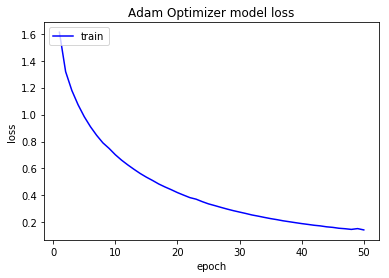

In [10]:
plt.plot(range(1, EPOCHS+1), lossArray, "b", label="train")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Adam Optimizer model loss")
plt.legend(loc = 2)
plt.show()

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "tmp")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [33]:
index = 18
print(test_inputs[index], end="\n\n")
print("Original comment: ",test_outputs[index], end="\n\n")
predict = simple_translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)
print("Predictedd translation: ", predict, end="\n\n")
bleu4_score = bleu4(test_outputs[index], predict)
print("bleu4: ", bleu4_score, end="\n\n")

public void mouseClicked(MouseEvent e){
  if (SwingUtilities.isRightMouseButton(e))   m_adaptee.popupMenu.show((Component)e.getSource(),e.getX(),e.getY());
}


Original comment:  Mouse Listener

Predictedd translation:  Mouse Listener 

bleu4:  1.0000000000625001e-05



In [42]:
comment_train[1]

array([ 7,  8,  9, 10, 11, 12, 13,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [43]:
comment_voc[7]

'Test'

In [ ]:
bleus = []

for index in range(len(test_inputs)):
    predict = translate(test_inputs[index], encoder, decoder, code_voc, comment_voc, max_length_inp, max_length_targ)
    bleus += [bleu4(test_outputs[index], predict)]
np.mean(bleus)

In [64]:
tf.test.is_gpu_available()


True